In [ ]:
!ls '../'

In [ ]:
!ls '../input/'

In [ ]:
!ls '../input/coco-2017-dataset/coco2017/'

In [ ]:
!ls '../input/coco-2017-dataset/coco2017/annotations/'

In [ ]:
!ls '../input/thesis-imgcapmydata-1/'

In [ ]:
!ls '../input/coco-2017-dataset/coco2017/train2017/' | wc -l

In [ ]:
!ls '../input/coco-2017-dataset/coco2017/val2017/' | wc -l

In [ ]:
!ls '../working/'

In [ ]:
!mkdir '../working/weights/'

In [ ]:
!ls '../working/weights/'

# Training model on the Coco Train2017 dataset

## Had already uploaded all 118287 images to Google drive and captures the os.listdir on the folder. Then in sets of 5k in that order of slicing the array created subsets. Ran those images through the bottleneck CNN-Encoder to get the image feature arrays. So will continue doing this.

## Total Images = 20000 images
## Train data = 19500 images
## Test  data = 500  images

## Note: each image will have multiple captions (up to 5 as some may be discarded)

## Using this LINK: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8
## Image captioning with Keras

In [1]:
import os
import sys
import json
import time
import datetime
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import re
import pickle
#import itertools
from sklearn.model_selection import train_test_split
import PIL
import PIL.Image

## import numpy as np
## from numpy import array
## import pandas as pd
## import matplotlib.pyplot as plt
## %matplotlib inline
## import string
## import os
## from PIL import Image
## import glob
## from pickle import dump, load
## from time import time
## from keras.preprocessing import sequence
## from keras.models import Sequential
## from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
## from keras.optimizers import Adam, RMSprop
## from keras.layers.wrappers import Bidirectional
## from keras.layers.merge import add
## from keras.applications.inception_v3 import InceptionV3
## from keras.preprocessing import image
## from keras.models import Model
## from keras import Input, layers
## from keras import optimizers
## from keras.applications.inception_v3 import preprocess_input
## from keras.preprocessing.text import Tokenizer
## from keras.preprocessing.sequence import pad_sequences
## from keras.utils import to_categorical

In [2]:
#from google.colab import drive
#drive.flush_and_unmount()
#drive.mount('/content/gdrive')

In [58]:
## Kaggle versions
OPDIR = r'../working/'
IPDIR_IMGS = r'../input/coco-2017-dataset/coco2017/train2017/'
IPDIR_ANNO = r'../input/coco-2017-dataset/coco2017/annotations/'
IPDIR_IMGENCODINGS = r'../input/thesis-imgcapmydata-1/'
IPDIR_EMBEDMATRIX = r'../input/thesis-imgcapmydata-1/'
#WORD_EMBEDDINGS_DIR = '/content/gdrive/My Drive/ThesisStoryGen/Data/WordEmbeddings/' #not needed as already created the embedding matrix and pickled

## Google drive versions
#OPDIR = '/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoVal2017_1/'
#IPDIRIMGS = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_val2017_wget_1/val2017/'
#IPDIRANNO = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_annotations_trainval2017/'
#WORD_EMBEDDINGS_DIR = '/content/gdrive/My Drive/ThesisStoryGen/Data/WordEmbeddings/'

## ALWAYS - Data Preprocessing — Images - RELOAD FROM PICKLE FILE: Image encodings info obtained from encoder
### e.g. a val2017 dataset image entry is: img_encodings['000000179765'] should be as below:

#### array([0.14290808, 0.14481388, 0.30199888, ..., 0.20583029, 0.1378399 ,
####        0.05842396], dtype=float32)

In [4]:
pickled_encodings_dicts = [
    'train2017_subset_5k_0_5000_images_encoded_features_pickled_1.pkl',
    'train2017_subset_5k_5000_10000_images_encoded_features_pickled_1.pkl',
    'train2017_subset_5k_10000_15000_images_encoded_features_pickled_1.pkl',
    'train2017_subset_5k_15000_20000_images_encoded_features_pickled_1.pkl'
]
## reload from picked file and merge them all into one dict
img_encodings = {}
for idx, encodings_dict_pickle_file in enumerate(pickled_encodings_dicts):
    with open(IPDIR_IMGENCODINGS+encodings_dict_pickle_file, 'rb') as handle:
        img_encodings.update(pickle.load(handle))
    print(f"Number of entries in encodings dict = {len(img_encodings)}")

print(f"Final count = {len(img_encodings)}")

Number of entries in encodings dict = 5000
Number of entries in encodings dict = 10000
Number of entries in encodings dict = 15000
Number of entries in encodings dict = 20000
Final count = 20000


In [5]:
## should be about = 147kB for each 5k subset
print(f"Size of reloaded pickled data = {sys.getsizeof(img_encodings)} bytes")

Size of reloaded pickled data = 589936 bytes


In [ ]:
img_encodings['000000002892']

## ONLY ONCE - create "descriptions" dictionary

In [6]:
## Now, we create a dictionary named “descriptions” which contains the name of the image
## (without the .jpg extension) as keys and a list captions for the corresponding
## image as values.

### Load the info from the Train2017 annotations file (i.e. captions_train2017.json) and process it

In [7]:
os.listdir(IPDIR_ANNO)

['instances_train2017.json',
 'captions_train2017.json',
 'instances_val2017.json',
 'person_keypoints_train2017.json',
 'person_keypoints_val2017.json',
 'captions_val2017.json']

In [8]:
## from the annotations file, load the captions

with open(IPDIR_ANNO+'captions_train2017.json', 'r') as f:
  data = json.load(f)
  #data.keys() # dict_keys(['info', 'licenses', 'images', 'annotations'])
  #type(data['annotations']) # is a list
  #type(data['images'])      # also is a list

dfanno = pd.DataFrame(data=data['annotations'])
# dfanno.columns = Index(['image_id', 'id', 'caption'], dtype='object') 
# dfanno.dtypes =
#   image_id     int64
#   id           int64
#   caption     object
#   dtype: object

dfimages = pd.DataFrame(data=data['images'])
# dfimages.columns = Index(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'], dtype='object')
# dfimages.dtypes =
#   license           int64
#   file_name        object
#   coco_url         object
#   height            int64
#   width             int64
#   date_captured    object
#   flickr_url       object
#   id                int64
#   dtype: object
## of above, am dropping useless columns
dfimages.drop(['license', 'coco_url', 'date_captured', 'flickr_url'], axis = 1, inplace=True)

## columns remaining in the dfs are:
# dfanno columns are      image_id , id , caption
#                         179765   , 38 ,	A black Honda motorcycle parked in front of a ...
# dfimages columns are    file_name        , height ,  width , id
#                         000000397133.jpg , 427    ,  640   , 397133

## the captions are not ordered for each image and seem to be randomly placed

dfanno.head(3)

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...


In [9]:
## marrying the "annotations" and the "images" keys info together into dfanno
## the file_name column has the actual image name from the "image" key section
dfanno = dfanno.merge(dfimages, how="inner", left_on='image_id', right_on='id')
dfanno.drop(['height', 'width', 'id_y'], axis = 1, inplace=True)
dfanno.rename(columns={'id_x':'id'}, inplace=True)
dfanno.head(3)

,image_id,id,caption,file_name
0,203564,37,A bicycle replica with a clock as the front wh...,000000203564.jpg
1,203564,181,The bike has a clock as a tire.,000000203564.jpg
2,203564,478,A black metal bicycle with a clock inside the ...,000000203564.jpg


In [10]:
## Mapping image with captions using dictionary

def create_descriptions_dictionary(_dfin):
    descriptions = {}
    for row in _dfin.itertuples():
      rowdict = row._asdict()
      img_filename = rowdict['file_name'].split('.')[0] # drop the .jpg part
      img_caption = rowdict['caption']
      if(img_filename not in descriptions):
        descriptions[img_filename] = [img_caption]
      else:
        descriptions[img_filename].append(img_caption)
    return descriptions

descriptions = create_descriptions_dictionary(dfanno)

## At this stage the descriptions dict has info for ALL train images.
## Since I am only using the first 4 subsets, access those filenames and retain that info:
### Using the img_encodings entries as reference (key is the file name, same key used by the descriptions dict), retain only in the descriptions

In [11]:
len(descriptions)  ## will be for all 118287 images of Train

118287

In [12]:
retain_dict = {}
for img in img_encodings.keys():
    retain_dict.update({img:descriptions[img]})
descriptions = retain_dict.copy()
del retain_dict
print(f"remaning entries in descriptions = {len(descriptions)}")  ## will be for all 118287 images of Train

remaning entries in descriptions = 20000


In [13]:
dict(list(descriptions.items())[11:14])

{'000000533900': ['A wooden bathroom with a wooden toilet next to a window.',
  'There is a wooden bench in a wooden room with a window. ',
  'A wooden outhouse has a pretty white window.',
  'An outhouse is shown with a toilet and window.',
  'A wooden bench in a room made of wood with a white, painted window.'],
 '000000031519': ['A group of rescue workers helping an overturned car',
  'A group of people are around the upside down car on the street. ',
  'a car over turned on a city street',
  'it is a scene of a crash with a vehicle overturned.',
  'An overturned car at the intersection of a city street.'],
 '000000005802': ['Two men wearing aprons working in a commercial-style kitchen.',
  'Chefs preparing food in a professional metallic style kitchen.',
  'Two people standing around in a large kitchen.',
  'A commercial kitchen with two men working to prepare several plates.',
  'two men in white shirts in a large steel kitchen']}

In [14]:
## example of caption with a hyphen - in the text
descriptions['000000005802']

['Two men wearing aprons working in a commercial-style kitchen.',
 'Chefs preparing food in a professional metallic style kitchen.',
 'Two people standing around in a large kitchen.',
 'A commercial kitchen with two men working to prepare several plates.',
 'two men in white shirts in a large steel kitchen']

### Data cleaning on the "descriptions" dictionary values

### Following clean up done:
### 1. lower casing
### 2. punctuation removal
### 3. remove any words with length = 1
### 4. remove any words with alphanumeric

In [15]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        # tokenize
        desc = desc.split()
        # convert to lower case
        desc = [word.lower() for word in desc]
        # remove punctuation from each token
        desc = [w.translate(table) for w in desc]
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        # store as string
        desc_list[i] =  ' '.join(desc)

In [16]:
## example of caption which had the hyphen - in the text
descriptions['000000005802']

['two men wearing aprons working in commercialstyle kitchen',
 'chefs preparing food in professional metallic style kitchen',
 'two people standing around in large kitchen',
 'commercial kitchen with two men working to prepare several plates',
 'two men in white shirts in large steel kitchen']

## ALWAYS - Using the descriptions dictionary, split IMAGE NAMES data into a train and val sets.
### Will make two lists containing only the file name without the .jpg

In [17]:
all_imgs_for_splitting = [key for key in descriptions.keys()]

TRAIN_SIZE_N = 19500 ## means balance used as the val data size.
train_imgs_arr, val_imgs_arr = train_test_split(all_imgs_for_splitting, train_size = TRAIN_SIZE_N, random_state=444)

print(f"Sizes of: Train = {len(train_imgs_arr)},  Val = {len(val_imgs_arr)},  Train = {len(all_imgs_for_splitting)}")
del all_imgs_for_splitting

Sizes of: Train = 19500,  Val = 500,  Train = 20000


In [18]:
OPDIR

'../working/'

In [19]:
## pickle the train and val lists
with open(OPDIR+'train_imgs_19500.pkl', 'wb') as handle:
  pickle.dump(train_imgs_arr, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Train img arr Pickling done")
with open(OPDIR+'val_imgs_500.pkl', 'wb') as handle:
  pickle.dump(val_imgs_arr, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Val img arr Pickling done")

Train img arr Pickling done
Val img arr Pickling done


## ALWAYS - Add the    startseq    and    endseq    tokens to all the descriptions and create 3 sets: one for all the descriptions, one for the train, one for the test

### At end of this section we will have four dictionaries of captions:
###    variable --------------------------------------------------- start/end seq present ---- which images
### 1) descriptions ------------------------------------------------------ NO ------------------------- all 5k
### 2) descriptions_all_start_end_seq ------------------------ YES -------------------------- all 5k
### 3) descriptions_train_start_end_seq -------------------- YES ----------------------- train number (4800)
### 4) descriptions_val_start_end_seq ----------------------- YES ----------------------- val number (200)

In [20]:
## see the unchanged descriptions - note no startseq and endseq present now
i=0
for k, v in descriptions.items():
  i+=1
  if i>5:
    break
  print(k, v)

000000071988 ['man in wheelchair and another sitting on bench that is overlooking the water', 'two people sitting on dock looking at the ocean', 'two older people sitting down in front of beach', 'an old couple at the beach during the day', 'person on bench and one on wheelchair sitting by seawall looking out toward the ocean']
000000581177 ['kitchen is shown with wooden cabinets and wooden celling', 'recently remodeled kitchen with marble and wooden furnishings', 'well kept kitchen with marble counter tops and stainless steel fridge', 'beautiful new kitchen with natural wood cabinets', 'neat wood filled kitchen is photographed as if for real estate ad']
000000208408 ['person walking in the rain on the sidewalk', 'person walking through the rain with an umbrella', 'person walking in the rain while holding an umbrella', 'man walks down the strip as it rains', 'european street scene with person and vehicles']
000000505386 ['four urinals in public restroom with window', 'bathroom with fou

In [21]:
## add startseq and endseq to the captions of all descriptions

descriptions_all_start_end_seq = descriptions.copy()

for k, v in descriptions_all_start_end_seq.items():
  updated_cap_arr = [''.join(['startseq ', caption, ' endseq']) for caption in v]
  descriptions_all_start_end_seq.update( { k : updated_cap_arr } )

In [22]:
## see the unchanged descriptions - note no startseq and endseq present STILL
i=0
for k, v in descriptions.items():
  i+=1
  if i>5:
    break
  print(k, v)

000000071988 ['man in wheelchair and another sitting on bench that is overlooking the water', 'two people sitting on dock looking at the ocean', 'two older people sitting down in front of beach', 'an old couple at the beach during the day', 'person on bench and one on wheelchair sitting by seawall looking out toward the ocean']
000000581177 ['kitchen is shown with wooden cabinets and wooden celling', 'recently remodeled kitchen with marble and wooden furnishings', 'well kept kitchen with marble counter tops and stainless steel fridge', 'beautiful new kitchen with natural wood cabinets', 'neat wood filled kitchen is photographed as if for real estate ad']
000000208408 ['person walking in the rain on the sidewalk', 'person walking through the rain with an umbrella', 'person walking in the rain while holding an umbrella', 'man walks down the strip as it rains', 'european street scene with person and vehicles']
000000505386 ['four urinals in public restroom with window', 'bathroom with fou

In [23]:
## see the changed descriptions - note startseq and endseq IS PRESENT in this copy
i=0
for k, v in descriptions_all_start_end_seq.items():
  i+=1
  if i>5:
    break
  print(k, v)

000000071988 ['startseq man in wheelchair and another sitting on bench that is overlooking the water endseq', 'startseq two people sitting on dock looking at the ocean endseq', 'startseq two older people sitting down in front of beach endseq', 'startseq an old couple at the beach during the day endseq', 'startseq person on bench and one on wheelchair sitting by seawall looking out toward the ocean endseq']
000000581177 ['startseq kitchen is shown with wooden cabinets and wooden celling endseq', 'startseq recently remodeled kitchen with marble and wooden furnishings endseq', 'startseq well kept kitchen with marble counter tops and stainless steel fridge endseq', 'startseq beautiful new kitchen with natural wood cabinets endseq', 'startseq neat wood filled kitchen is photographed as if for real estate ad endseq']
000000208408 ['startseq person walking in the rain on the sidewalk endseq', 'startseq person walking through the rain with an umbrella endseq', 'startseq person walking in the r

In [24]:
## using the train and val arrays of image names (which match our keys in descriptions),
## create the descriptiosn for the train and val

In [25]:
## make copies of all images descriptions, then remove suitable items from each
descriptions_train_start_end_seq = descriptions_all_start_end_seq.copy()
descriptions_val_start_end_seq = descriptions_all_start_end_seq.copy()

for key_train in train_imgs_arr:
  del descriptions_val_start_end_seq[key_train]
for key_val in val_imgs_arr:
  del descriptions_train_start_end_seq[key_val]
print(f"Sizes of descriptions dicts for: Train = {len(descriptions_train_start_end_seq)},  Val = {len(descriptions_val_start_end_seq)},  Train = {len(descriptions_all_start_end_seq)}")

Sizes of descriptions dicts for: Train = 19500,  Val = 500,  Train = 20000


In [26]:
## see the train descriptions - note startseq and endseq IS PRESENT
i=0
for k, v in descriptions_train_start_end_seq.items():
  i+=1
  if i>5:
    break
  print(k, v)

000000071988 ['startseq man in wheelchair and another sitting on bench that is overlooking the water endseq', 'startseq two people sitting on dock looking at the ocean endseq', 'startseq two older people sitting down in front of beach endseq', 'startseq an old couple at the beach during the day endseq', 'startseq person on bench and one on wheelchair sitting by seawall looking out toward the ocean endseq']
000000581177 ['startseq kitchen is shown with wooden cabinets and wooden celling endseq', 'startseq recently remodeled kitchen with marble and wooden furnishings endseq', 'startseq well kept kitchen with marble counter tops and stainless steel fridge endseq', 'startseq beautiful new kitchen with natural wood cabinets endseq', 'startseq neat wood filled kitchen is photographed as if for real estate ad endseq']
000000208408 ['startseq person walking in the rain on the sidewalk endseq', 'startseq person walking through the rain with an umbrella endseq', 'startseq person walking in the r

In [27]:
## see the val descriptions - note startseq and endseq IS PRESENT
i=0
for k, v in descriptions_val_start_end_seq.items():
  i+=1
  if i>5:
    break
  print(k, v)

000000242363 ['startseq bathroom with sink toilet and shower bathtub combination endseq', 'startseq bathroom with vanity sink and toilet but empty walls endseq', 'startseq bathroom complete with tub toilet and sink endseq', 'startseq picture of three piece bathroom that is all white and beige endseq', 'startseq an empty bathroom with toilet bathtub and sink endseq']
000000146112 ['startseq man standing next to bike inside of building endseq', 'startseq man is standing on platform with his bicycle dressed in jersey and bike shorts with two women at table behind him endseq', 'startseq man wearing biking apparel standing inside building with his bike endseq', 'startseq man speaking into microphone on stage with bicycle and dressed in cyclist gear endseq', 'startseq man in cycling clothes drinking beside his bicycle endseq']
000000469840 ['startseq man and child on red and black motorcycle endseq', 'startseq man in overalls sitting on motorcycle with baby endseq', 'startseq man and boy get

In [28]:
list(descriptions_train_start_end_seq.keys())[:5]

['000000071988',
 '000000581177',
 '000000208408',
 '000000505386',
 '000000321064']

In [29]:
## NOTE : I think i need to only descriptions_train_start_end_seq to build vocab (all or culled). Then on its wordtoix, add 1 to make that VOCAB_LEN for the model. So deleting uselss:
del descriptions_all_start_end_seq

# Vocabulary building
## ALWAYS - Create the vocabulary based on the captions in the "descriptions_train_start_end_seq" dictionary

###**NOTE: FOR NOW USING THE ALL THE 5K IMAGES CAPTIONS**
###**LATER CONSIDER USING ONLY THE TRAIN 4800 CAPTIONS!!!!!!!**

### First for all the words
### Then culled based on frequency > threshold

In [30]:
## earlier was using descriptions BUT NOW using descriptions_train_start_end_seq
vocabulary = set()
#for key in descriptions.keys():
#    [vocabulary.update(d.split()) for d in descriptions[key]]
for key in descriptions_train_start_end_seq.keys():
    [vocabulary.update(d.split()) for d in descriptions_train_start_end_seq[key]]
print(f"Original Vocabulary Size: {len(vocabulary)}")

Original Vocabulary Size: 12982


In [31]:
## This means we have 12982 unique words across all the captions for the 19500 train set images
## 
## However, if we think about it, many of these words will occur very few times, 
## say 1, 2 or 3 times. Since we are creating a predictive model, we would not like 
## to have all the words present in our vocabulary but the words which are more 
## likely to occur or which are common. This helps the model become more robust 
## to outliers and make less mistakes.
##
## Hence we consider only those words which occur at least 10 times in the entire corpus.

### Cull vocabulary based on frequency > threshold
### Capturing new data into variable   vocab_threshold

In [32]:
# Create a list of all the training captions
## for now treating all the 5k images in coco val2017 as training data
##     so using all the captions

all_captions = []
#for key, val in descriptions.items():   ## LATER MAYBE USE descriptions_train_start_end_seq - YES TRYING THAT NOW
for key, val in descriptions_train_start_end_seq.items():   ## LATER MAYBE USE descriptions_train_start_end_seq - YES TRYING THAT NOW
    for cap in val:
        all_captions.append(cap)

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab_threshold = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print(f"Preprocessed words occurring more than threshold = {word_count_threshold} times , \n={len(vocab_threshold)}")

Preprocessed words occurring more than threshold = 10 times , 
=3207


In [33]:
## Thus from 12982 unique words in original vocabulary,
## the count of unique words is now 3207 in the vocab_threshold

## So we now have two vocabulary variables:
#### 1) vocabulary
####    list of ALL unique words in our 5k captions
#### 2) vocab_threshold
####    list of unique words occuring MORE than the threshold limit

## NOTE: Eventually though we will be zero-padding, so the total words = len(vocab_threshold) + 1
##       Additional one index for the 0
###      i.e. 3207 + 1 = 3208

## ALWAYS - Data Preprocessing — Captions
### 1) Build the word and index mapping dictionaries based on the reduced vocabulary.
### 2) Find the maximum length of captions
###    NOTE: This is using the train images descriptions WITH the startseq and endseq word insertions

In [34]:
### We want to predict the captions. So while training, the captions are the target variables (Y)
### But the prediction of caption happens word by word, not in one go.
### So encode each word into a fixed sized vector later (GloVe).
### Here create the word-to-index and index-to-word dictionaries.
###
### We represent every unique word in the vocabulary by an integer (index).
### From the culled vocab (high freq words including the zero), we have 1523 unique words
###      in our corpus and thus each word will be represented by an integer index between 1 to 1523.
###
### Create two dictionaries:
###        wordtoix[‘abc’] -> returns index of the word ‘abc’
###        ixtoword[k] -> returns the word whose index is ‘k’

In [35]:
## NOTE: using the vocab_threhold
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab_threshold:
  wordtoix[w] = ix
  ixtoword[ix] = w
  ix += 1

In [36]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
 all_desc = list()
 for key in descriptions.keys():
  [all_desc.append(d) for d in descriptions[key]]
 return all_desc
# calculate the length of the description with the most words
def max_length(descriptions):
 lines = to_lines(descriptions)
 return max(len(d.split()) for d in lines)

### Find value of MAX_LENGTH_CAPTION

#### MAYBE TRY LATER WITH THE DESCRIPTIONS WITH THE STARTSEQ AND ENDSEQ -- trying that now
#### I.E. VARAIBLE descriptions_all_start_end_seq - BUT with descriptions_train_start_end_seq as the vocab_threhold built with it too

In [37]:
# determine the maximum sequence length
#MAX_LENGTH_CAPTION = max_length(descriptions)  ## will be used directly later while defining Decoder model
MAX_LENGTH_CAPTION = max_length(descriptions_train_start_end_seq)  ## will be used directly later while defining Decoder model
print(f"Max Description Length: {MAX_LENGTH_CAPTION}")

Max Description Length: 43


In [38]:
[cap for val in descriptions_train_start_end_seq.values() for cap in val][:8]

['startseq man in wheelchair and another sitting on bench that is overlooking the water endseq',
 'startseq two people sitting on dock looking at the ocean endseq',
 'startseq two older people sitting down in front of beach endseq',
 'startseq an old couple at the beach during the day endseq',
 'startseq person on bench and one on wheelchair sitting by seawall looking out toward the ocean endseq',
 'startseq kitchen is shown with wooden cabinets and wooden celling endseq',
 'startseq recently remodeled kitchen with marble and wooden furnishings endseq',
 'startseq well kept kitchen with marble counter tops and stainless steel fridge endseq']

In [39]:
df = pd.DataFrame(data=[cap for val in descriptions_train_start_end_seq.values() for cap in val],columns=['sent'])
df['caplen'] = df['sent'].str.split().apply(len)
df['sent'][df['caplen'] == 43]

33587    startseq dining car of train with people seate...
95376    startseq pink door way shows white walled room...
Name: sent, dtype: object

In [40]:
df = pd.DataFrame(data=[cap for val in descriptions_train_start_end_seq.values() for cap in val],columns=['sent'])
count = df['sent'].str.split().apply(len).value_counts()
count.index = count.index.astype(str)# + ' words:'
count.sort_index(inplace=True, ascending=False)
count.head(10)

9     19041
8      7648
7       707
6         1
43        2
42        2
41        4
4         1
39        3
38        4
Name: sent, dtype: int64

## Data Preparation using Generator Function

In [ ]:
## Hereafter, I will try to explain the remaining steps by taking a sample example as follows:
## Consider we have 3 images and their 3 corresponding captions as follows:
## 
## (Train image 1) Caption -> The black cat sat on grass
## (Train image 2) Caption -> The white cat is walking on road
## (Test image) Caption -> The black cat is walking on grass
## 
## Now, let’s say we use the first two images and their captions to train the model and the third image to test our model.
## Now the questions that will be answered are: how do we frame this as a supervised learning problem?, what does the data matrix look like? how many data points do we have?, etc.
## First we need to convert both the images to their corresponding 2048 length feature vector as discussed above. Let “Image_1” and “Image_2” be the feature vectors of the first two images respectively
## Secondly, let’s build the vocabulary for the first two (train) captions by adding the two tokens “startseq” and “endseq” in both of them: (Assume we have already performed the basic cleaning steps)
## 
## Caption_1 -> “startseq the black cat sat on grass endseq”
## Caption_2 -> “startseq the white cat is walking on road endseq”
## 
## vocab = {black, cat, endseq, grass, is, on, road, sat, startseq, the, walking, white}
## 
## Let’s give an index to each word in the vocabulary:
## black -1, cat -2, endseq -3, grass -4, is -5, on -6, road -7, sat -8, startseq -9, the -10, walking -11, white -12
## 
## Now let’s try to frame it as a supervised learning problem where we have a set of data points D = {Xi, Yi}, where Xi is the feature vector of data point ‘i’ and Yi is the corresponding target variable.
## 
## Let’s take the first image vector Image_1 and its corresponding caption “startseq the black cat sat on grass endseq”. Recall that, Image vector is the input and the caption is what we need to predict. But the way we predict the caption is as follows:
## For the first time, we provide the image vector and the first word as input and try to predict the second word, i.e.:
## Input = Image_1 + ‘startseq’; Output = ‘the’
## Then we provide image vector and the first two words as input and try to predict the third word, i.e.:
## Input = Image_1 + ‘startseq the’; Output = ‘cat’
## And so on . . .
## 
## Thus, we can summarize the data matrix for one image and its corresponding caption as follows:
## Step 1 :: image feature = FeatVecImg1 :: Partial Caption = "startseq" :: Target Word = "the"
## Step 2 :: image feature = FeatVecImg1 :: Partial Caption = "startseq the" :: Target Word = "black"
## Step 3 :: image feature = FeatVecImg1 :: Partial Caption = "startseq the black" :: Target Word = "cat"
## Step 4 :: image feature = FeatVecImg1 :: Partial Caption = "startseq the black cat" :: Target Word = "sat"
## Step 5 :: image feature = FeatVecImg1 :: Partial Caption = "startseq the black cat sat" :: Target Word = "on"
## Step 6 :: image feature = FeatVecImg1 :: Partial Caption = "startseq the black cat sat on" :: Target Word = "grass"
## Step 7 :: image feature = FeatVecImg1 :: Partial Caption = "startseq the black cat sat on grass" :: Target Word = "endseq"
## 
## It must be noted that, one image+caption is not a single data point but are multiple data points depending on the length of the caption.
## All the above 7 data points together constitute the full data for one image and its caption!!!!
## Similarly for second images, there will be multiple steps together that consitute its full data point.
## 
## We must now understand that in every data point, it’s not just the image which goes as input to the system, but also, a partial caption which helps to predict the next word in the sequence.
## Since we are processing sequences, we will employ a Recurrent Neural Network to read these partial captions (more on this later).
## However, we have already discussed that we are not going to pass the actual English text of the caption, rather we are going to pass the sequence of indices where each index represents a unique word.
## 
## Since we have already created an index for each word, let’s now replace the words with their indices and understand how the data matrix will look like:
## Step 1  :: image feature = FeatVecImg1 :: Partial Caption = "9" :: Target Word = "10"
## Step 2  :: image feature = FeatVecImg1 :: Partial Caption = "9 10" :: Target Word = "1"
## Step 3  :: image feature = FeatVecImg1 :: Partial Caption = "9 10 1" :: Target Word = "2"
## Step 4  :: image feature = FeatVecImg1 :: Partial Caption = "9 10 1 2" :: Target Word = "8"
## Step 5  :: image feature = FeatVecImg1 :: Partial Caption = "9 10 1 2 8" :: Target Word = "6"
## Step 6  :: image feature = FeatVecImg1 :: Partial Caption = "9 10 1 2 8 6" :: Target Word = "4"
## Step 7  :: image feature = FeatVecImg1 :: Partial Caption = "9 10 1 2 8 6 4" :: Target Word = "3"
## Step 8  :: image feature = FeatVecImg2 :: Partial Caption = "9" :: Target Word = "10"
## Step 9  :: image feature = FeatVecImg2 :: Partial Caption = "9 10" :: Target Word = "12"
## Step 10 :: image feature = FeatVecImg2 :: Partial Caption = "9 10 12" :: Target Word = "2"
## Step 11 :: image feature = FeatVecImg2 :: Partial Caption = "9 10 12 2" :: Target Word = "5"
## Step 12 :: image feature = FeatVecImg2 :: Partial Caption = "9 10 12 2 5" :: Target Word = "11"
## Step 13 :: image feature = FeatVecImg2 :: Partial Caption = "9 10 12 2 5 11" :: Target Word = "6"
## Step 14 :: image feature = FeatVecImg2 :: Partial Caption = "9 10 12 2 5 11 6" :: Target Word = "7"
## Step 15 :: image feature = FeatVecImg2 :: Partial Caption = "9 10 12 2 5 11 6 3" :: Target Word = "3"
## 
## Since we would be doing batch processing (explained later), we need to make sure that each sequence is of equal length. Hence we need to append 0’s (zero padding) at the end of each sequence. But how many zeros should we append in each sequence?
## Well, this is the reason we had calculated the maximum length of a caption. So we will append those many number of zeros which will lead to every sequence having a length = maximum length of caption.
## 
## Step 1  :: image feature = FeatVecImg1 :: Partial Caption = "[9 0 0 ...]" :: Target Word = "10"
## Step 2  :: image feature = FeatVecImg1 :: Partial Caption = "[9 10 0 0 ...]" :: Target Word = "1"
## Step 3  :: image feature = FeatVecImg1 :: Partial Caption = "[9 10 1 0 0 ...]" :: Target Word = "2"
## Step 4  :: image feature = FeatVecImg1 :: Partial Caption = "[9 10 1 2 0 0 ...]" :: Target Word = "8"
## Step 5  :: image feature = FeatVecImg1 :: Partial Caption = "[9 10 1 2 8 0 0 ...]" :: Target Word = "6"
## Step 6  :: image feature = FeatVecImg1 :: Partial Caption = "[9 10 1 2 8 6 0 0 ...]" :: Target Word = "4"
## Step 7  :: image feature = FeatVecImg1 :: Partial Caption = "[9 10 1 2 8 6 4 0 0 ...]" :: Target Word = "3"
## Step 8  :: image feature = FeatVecImg2 :: Partial Caption = "[9 0 0 ...]" :: Target Word = "10"
## Step 9  :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 0 0 ...]" :: Target Word = "12"
## Step 10 :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 12 0 0 ...]" :: Target Word = "2"
## Step 11 :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 12 2 0 0 ...]" :: Target Word = "5"
## Step 12 :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 12 2 5 0 0 ...]" :: Target Word = "11"
## Step 13 :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 12 2 5 11 0 0 ...]" :: Target Word = "6"
## Step 14 :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 12 2 5 11 6 0 0 ...]" :: Target Word = "7"
## Step 15 :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 12 2 5 11 6 3 0 0 ...]" :: Target Word = "3"
## Appended adequete 0's to each partial caption to make its length = max length
## 
## 
## 
## Need for a Data Generator:
## In the above example, I have only considered 2 images and captions which have lead to 15 data points.
## However, in our actual training dataset we have 6000 images, each having 5 captions. This makes a total of 30000 images and captions.
## Even if we assume that each caption on an average is just 7 words long, it will lead to a total of 30000*7 i.e. 210000 data points.
## 
## Compute the size of the data matrix:
## 
## 
##    img_vector = 2048        partial caption (length = max caption length)
## ---------------------------------------------------------------------------
## -                       -                                                 -
## -                       -                                                 -
## -                       -                                                 -
## -                       -                                                 -
## ---------------------------------------------------------------------------
## Say above matrix has n rows, m columns, so Size of the data matrix = n*m
## n-> number of data points (assumed as 210000)  (6000 images * 5 captions per image * 7 words average legnth of each caption)
## m-> length of each data point
##     = 2048 + length of partial caption (say something)
##     = 2048 + something
## 
## Now this "something"  NOTE EQUAL to the max length of caption!
## Every word (or index) will be mapped (embedded) to higher dimensional space through one of the word embedding techniques.
## As we using GloVe-200, each embedding has 200 floats representing each number.
## 
## So with each caption sentence consisting of max length caption size word-indexes, each word represented by 200 dimensional value:
##    Assuming max lenght of caption = 45
##    means "something" = 2048 + ( 45 * 200 ) = 2048 + 9000 = 11048 float values to represent each sentence
## 
## Therefore, size of data matrix = m*n = 210000 * 11048 = xxx float values!!!
## Assuming float takes 2 bytes (very conservative), that still means xxx * 2 = xxx GB
## 
## This is pretty huge requirement and even if we are able to manage to load this much data into the RAM, it will make the system very slow.
## For this reason we use data generators a lot in Deep Learning. Data Generators are a functionality which is natively implemented in Python. The ImageDataGenerator class provided by the Keras API is nothing but an implementation of generator function in Python.
## 
## So how does using a generator function solve this problem?
## If you know the basics of Deep Learning, then you must know that to train a model on a particular dataset, we use some version of Stochastic Gradient Descent (SGD) like Adam, Rmsprop, Adagrad, etc.
## With SGD, we do not calculate the loss on the entire data set to update the gradients. Rather in every iteration, we calculate the loss on a batch of data points (typically 64, 128, 256, etc.) to update the gradients.
## 
## This means that we do not require to store the entire dataset in the memory at once. Even if we have the current batch of points in the memory, it is sufficient for our purpose.
## A generator function in Python is used exactly for this purpose. It’s like an iterator which resumes the functionality from the point it left the last time it was called.
## To understand more about Generators, please read here (https://wiki.python.org/moin/Generators).
## 

In [ ]:
# data generator, use during the call to model.fit_generator() to create batchwise data
def data_generator_1(_descriptions, _imgs_features_arr, _wordtoix, _max_length, _images_per_batch, _vocab_size):
    X1, X2, y = [] , [] , []  ## empty lists to populate the input and target data for a bath
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in _descriptions.items():
            n+=1
            # retrieve the encoded features of image
            img_feat = _imgs_features_arr[ key ] # + '.jpg' ]  ## I am not using the .jpg in the key of image features array
            for desc in desc_list:
                # encode the sequence
                seq = [_wordtoix[word] for word in desc.split(' ') if word in _wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=_max_length)[0]
                    # encode output sequence
                    out_seq = keras.utils.to_categorical([out_seq], num_classes=_vocab_size)[0]
                    # store
                    X1.append(img_feat)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == _images_per_batch:
                ## ValueError: No gradients provided for any variable: ['dense_2/kernel:0', 'dense_2/bias:0', 'lstm_1/lstm_cell_1/kernel:0', 'lstm_1/lstm_cell_1/recurrent_kernel:0', 'lstm_1/lstm_cell_1/bias:0', 'dense_3/kernel:0', 'dense_3/bias:0', 'dense_4/kernel:0', 'dense_4/bias:0'].
                #yield [[np.array(X1), np.array(X2)], np.array(y)]
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# data generator, use during the call to model.fit_generator() to create batchwise data
def data_generator_2(_descriptions, _imgs_features_arr, _wordtoix, _max_length, _images_per_batch, _vocab_size):
    X1, X2, y = [] , [] , []  ## empty lists to populate the input and target data for a bath
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in _descriptions.items():
            n+=1
            # retrieve the encoded features of image
            img_feat = _imgs_features_arr[ key ] # + '.jpg' ]  ## I am not using the .jpg in the key of image features array
            for desc in desc_list:
                # encode the sequence
                seq = [_wordtoix[word] for word in desc.split(' ') if word in _wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=_max_length)[0]
                    # encode output sequence
                    out_seq = keras.utils.to_categorical([out_seq], num_classes=_vocab_size)[0]
                    # store
                    X1.append(img_feat)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == _images_per_batch:
                ## ValueError: No gradients provided for any variable: ['dense_2/kernel:0', 'dense_2/bias:0', 'lstm_1/lstm_cell_1/kernel:0', 'lstm_1/lstm_cell_1/recurrent_kernel:0', 'lstm_1/lstm_cell_1/bias:0', 'dense_3/kernel:0', 'dense_3/bias:0', 'dense_4/kernel:0', 'dense_4/bias:0'].
                #yield [[np.array(X1), np.array(X2)], np.array(y)]
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = list(), list(), list()
                n=0

## ALWAYS - RELOAD FROM PICKLE FILE:  Reload the GloVe vectors related data structures

### Sizes of reloaded pickled data should be =
#### Size of embeddings_dict_glove200 = 20.971616 MB

### Citing GloVe: Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]GloVe: Global Vectors for Word Representation. [pdf] [bib]
### Link: More details on this here- https://nlp.stanford.edu/projects/glove/

In [41]:
## Already downloaded the glove file and used it to create the embeddings dict and pickled it. Reloading now.
###    This data is made available under the Public Domain Dedication and License v1.0 whose full text can be found at: http://www.opendatacommons.org/licenses/pddl/1.0/.
###    Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): glove.6B.zip
###    Common Crawl (42B tokens, 1.9M vocab, uncased, 300d vectors, 1.75 GB download): glove.42B.300d.zip
###    Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download): glove.840B.300d.zip
###    Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip

### Am using glove.6B.zip on 14.09.2020
### Then its glove.6B.200d.txt file for the 200 dimensional word embeddings

In [42]:
IPDIR_EMBEDMATRIX

'../input/thesis-imgcapmydata-1/'

In [43]:
## reload from picked file

if True:
  with open(IPDIR_EMBEDMATRIX+'glove200_embeddings_dict_1.pkl', 'rb') as handle:
    embeddings_dict_glove200 = pickle.load(handle)

print(f"Number of words in this embeddings file = {len(embeddings_dict_glove200)}")
print(f"Shape of random word = {embeddings_dict_glove200['1917'].shape}")
print(f"Shape of another random word = {embeddings_dict_glove200['sculpture'].shape}")
print(f"Size of embeddings_dict_glove200 = {sys.getsizeof(embeddings_dict_glove200)/1000000} MB")

Number of words in this embeddings file = 400000
Shape of random word = (200,)
Shape of another random word = (200,)
Size of embeddings_dict_glove200 = 20.971624 MB


### Now create the EMBEDDINGS MATRIX using the embeddings dict

In [44]:
## Now, for all the 1522 unique words in our vocabulary, we create an embedding matrix
##      which will be loaded into the model before training.

In [45]:
len(wordtoix)

3207

In [46]:
print( wordtoix.get('startseq') , wordtoix.get('endseq') , wordtoix.get('cat') )

1 15 530


In [47]:
EMBEDDING_DIMS = 200
#VOCAB_SIZE = 7244 # number of unique words in the vocabulary
VOCAB_SIZE = len(wordtoix) + 1 # number of unique high freq words in the vocabulary + 1 (one index for the 0)

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIMS))
for word, i in wordtoix.items():
    #if i < max_words:
    ## using .get(word) method and not [word] as second method throws key error, while first returns none.
    ##        E.g.    print(embeddings_dict_glove200.get('sculture')) = None
    ##            But print(embeddings_dict_glove200['sculture'}) will break with key error
    embedding_vector = embeddings_dict_glove200.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

print(f"Shape of embedding_matrix = {embedding_matrix.shape}")

Shape of embedding_matrix = (3208, 200)


In [48]:
## e.g. of a word PRESENT the GoVe200 data file
mytestword = 'sculpture'
print(f"Index position of word {mytestword} in the vocabulary = {wordtoix.get(mytestword)}")
print(f"\nEmbedding vector for word 'sculpture' from GloVe directly = {embeddings_dict_glove200.get(mytestword)}")
print(f"\nembedding_matrix entry for '{mytestword}' = {embeddings_dict_glove200.get(mytestword)}")
## it should match

Index position of word sculpture in the vocabulary = 2580

Embedding vector for word 'sculpture' from GloVe directly = [ 0.24496   -0.43193   -0.45643   -0.19918    0.51172   -1.0377
  0.25122    0.12462    0.10547   -0.97614    0.53084   -0.1065
  0.37079    0.68693    0.87499   -0.20523   -0.3771     0.2687
  0.83217   -0.31284    0.014147   1.2787     0.68525   -0.11444
  0.16005    0.72932    0.39781   -0.69046   -0.04684   -0.16001
  0.16502   -0.25699    0.13922   -0.12093   -0.048757   0.0030296
 -0.51352   -0.79619    0.78581   -0.42436   -0.47878   -0.28729
  0.36649    0.27928    0.32741    0.37925    0.59473   -0.28681
  0.066106   0.29147    0.059296   0.71001   -0.14208   -0.063589
  0.076285  -0.027859   0.092648   0.16012    0.36895   -0.37574
 -0.27742    0.2595     0.060266   0.0081959 -0.4189     0.46089
 -0.65505   -0.13595   -0.47514   -0.5632    -0.2457    -0.85826
 -0.25973    0.66389    0.20883   -0.34182   -0.29798    0.10557
 -0.87879   -0.51638    0.7632    -0

In [49]:
## e.g. of a word NOT PRESENT the GoVe200 data file
## answer None in all cases since the word is not in the vocabulary itself the other two will throw key error
mytestword = 'sculture'
print(f"Index position of word {mytestword} in the vocabulary = {wordtoix.get(mytestword)}")
print(f"\nEmbedding vector for word 'sculpture' from GloVe directly = {embeddings_dict_glove200.get(mytestword)}")
print(f"\nembedding_matrix entry for '{mytestword}' = {embeddings_dict_glove200.get(mytestword)}")

Index position of word sculture in the vocabulary = None

Embedding vector for word 'sculpture' from GloVe directly = None

embedding_matrix entry for 'sculture' = None


## ALWAYS - Define the RNN Decoder model
## Use the GloVe embeddings matrix values to update layer weights and freeze ONLY those weights


### About Keras Emebedding layer
### 
#### Default initializing of this layer: https://keras.io/api/layers/core_layers/embedding/
######tf.keras.layers.Embedding(
######    input_dim, output_dim,
######    embeddings_initializer="uniform",
######    embeddings_regularizer=None,
######    activity_regularizer=None,
######    embeddings_constraint=None,
######    mask_zero=False,
######    input_length=None,
######    **kwargs
######)

In [ ]:
# Decoder Model defining

## parameters to define model
#EMBEDDING_DIMS is initialised earlier while creating embedding matrix
#VOCAB_SIZE is initialised earlier
#MAX_LENGTH_CAPTION is initialised earlier

inputs1 = keras.Input(shape=(2048,))
fe1 = keras.layers.Dropout(0.5)(inputs1)
fe2 = keras.layers.Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = keras.Input(shape=(MAX_LENGTH_CAPTION,))
se1 = keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIMS, mask_zero=True)(inputs2)
se2 = keras.layers.Dropout(0.5)(se1)
se3 = keras.layers.LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = keras.layers.add([fe2, se3])
decoder2 = keras.layers.Dense(256, activation='relu')(decoder1)
outputs = keras.layers.Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# merge the two input models
model_RNN_decoder = keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
#model_RNN_decoder.summary()

#This was the output:
#Model: "functional_3"
#__________________________________________________________________________________________________
#Layer (type)                    Output Shape         Param #     Connected to                     
#==================================================================================================
#input_7 (InputLayer)            [(None, 45)]         0                                            
#__________________________________________________________________________________________________
#input_6 (InputLayer)            [(None, 2048)]       0                                            
#__________________________________________________________________________________________________
#embedding_1 (Embedding)         (None, 45, 200)      304600      input_7[0][0]                    
#__________________________________________________________________________________________________
#dropout_3 (Dropout)             (None, 2048)         0           input_6[0][0]                    
#__________________________________________________________________________________________________
#dropout_4 (Dropout)             (None, 45, 200)      0           embedding_1[0][0]                
#__________________________________________________________________________________________________
#dense_2 (Dense)                 (None, 256)          524544      dropout_3[0][0]                  
#__________________________________________________________________________________________________
#lstm_1 (LSTM)                   (None, 256)          467968      dropout_4[0][0]                  
#__________________________________________________________________________________________________
#add (Add)                       (None, 256)          0           dense_2[0][0]                    
#                                                                 lstm_1[0][0]                     
#__________________________________________________________________________________________________
#dense_3 (Dense)                 (None, 256)          65792       add[0][0]                        
#__________________________________________________________________________________________________
#dense_4 (Dense)                 (None, 1523)         391411      dense_3[0][0]                    
#==================================================================================================
#Total params: 1,754,315
#Trainable params: 1,754,315
#Non-trainable params: 0
#__________________________________________________________________________________________________

In [ ]:
#tf.keras.utils.plot_model(model_RNN_decoder, to_file=OPDIR+'RNN_decoder_model_plot_1.jpg', show_shapes=True, show_layer_names=True)

### ALWAYS - set weights using the GloVe embedding matrix and freeze it

In [ ]:
embedding_matrix.shape

In [ ]:
model_RNN_decoder.layers[2].set_weights([embedding_matrix])
model_RNN_decoder.layers[2].trainable = False

### DO ONCE - RNN Decoder summary and plot
#### AFTER loading GloVe embeddings and Freezing

In [ ]:
#model_RNN_decoder.summary()

#This was the output:
#Model: "functional_3"
#__________________________________________________________________________________________________
#Layer (type)                    Output Shape         Param #     Connected to                     
#==================================================================================================
#input_7 (InputLayer)            [(None, 45)]         0                                            
#__________________________________________________________________________________________________
#input_6 (InputLayer)            [(None, 2048)]       0                                            
#__________________________________________________________________________________________________
#embedding_1 (Embedding)         (None, 45, 200)      304600      input_7[0][0]                    
#__________________________________________________________________________________________________
#dropout_3 (Dropout)             (None, 2048)         0           input_6[0][0]                    
#__________________________________________________________________________________________________
#dropout_4 (Dropout)             (None, 45, 200)      0           embedding_1[0][0]                
#__________________________________________________________________________________________________
#dense_2 (Dense)                 (None, 256)          524544      dropout_3[0][0]                  
#__________________________________________________________________________________________________
#lstm_1 (LSTM)                   (None, 256)          467968      dropout_4[0][0]                  
#__________________________________________________________________________________________________
#add (Add)                       (None, 256)          0           dense_2[0][0]                    
#                                                                 lstm_1[0][0]                     
#__________________________________________________________________________________________________
#dense_3 (Dense)                 (None, 256)          65792       add[0][0]                        
#__________________________________________________________________________________________________
#dense_4 (Dense)                 (None, 1523)         391411      dense_3[0][0]                    
#==================================================================================================
#Total params: 1,754,315
#Trainable params: 1,449,715
#Non-trainable params: 304,600
#__________________________________________________________________________________________________

In [ ]:
#tf.keras.utils.plot_model(model_RNN_decoder, to_file=OPDIR+'RNN_decoder_model_plot_AFTER_GLOVE_1.jpg', show_shapes=True, show_layer_names=True)

### ALWAYS - Compile RNN model

In [ ]:
model_RNN_decoder.compile(loss='categorical_crossentropy', optimizer='adam')

## ALWAYS - Train the RNN Decoder

In [ ]:
os.listdir(OPDIR + 'weights/')

In [ ]:
## values set earlier - for reference

print(f"MAX_LENGTH_CAPTION = {MAX_LENGTH_CAPTION}")
print(f"VOCAB_SIZE = {VOCAB_SIZE}")

In [ ]:
## For reference: def data_generator(_descriptions, _imgs_features_arr, _wordtoix, _max_length, _images_per_batch):
## Notes:
##      1) Ok to use the img_encodings array of Train and Test images. COZ function starts with the image name as key from the descriptions.

########### Phase 1 #########

print(f"\n\nTraining Phase 1 started at :: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

LR_1 = 0.0005
BATCH_SIZE_1 = 8   ## how many images per batch
N_EPOCHS_1 = 15
STEPS_PER_EPOCH_1 = len(descriptions_train_start_end_seq) // BATCH_SIZE_1
print(f"\nPhase 1 parameters:")
print(f"STEPS_PER_EPOCH_1 = {STEPS_PER_EPOCH_1}")
print(f"BATCH_SIZE_1 = {BATCH_SIZE_1}")
print(f"N_EPOCHS_1 = {N_EPOCHS_1}")

model_RNN_decoder.optimizer.lr = LR_1
for i in range(N_EPOCHS_1):
    generator_1 = data_generator_1(descriptions_train_start_end_seq, img_encodings, wordtoix, MAX_LENGTH_CAPTION, BATCH_SIZE_1, VOCAB_SIZE)
    model_RNN_decoder.fit_generator(generator_1, epochs=1, steps_per_epoch=STEPS_PER_EPOCH_1, verbose=1)
    if (i+1) >= 5 or i//2 == 1:
        model_RNN_decoder.save_weights( OPDIR + r'weights/' + 'RNNDecoder_Weights_Ph1_ep' + str(i) + '.h5' )

In [ ]:
########### Phase 2 #########

print(f"\n\nTraining Phase 2 started at :: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

LR_2 = 0.0001
BATCH_SIZE_2 = 16   ## how many images per batch
N_EPOCHS_2 = 15
STEPS_PER_EPOCH_2 = len(descriptions_train_start_end_seq) // BATCH_SIZE_2
print(f"\nPhase 2 parameters:")
print(f"STEPS_PER_EPOCH_2 = {STEPS_PER_EPOCH_2}")
print(f"BATCH_SIZE_2 = {BATCH_SIZE_2}")
print(f"N_EPOCHS_2 = {N_EPOCHS_2}")
print(f"LR_2 = {LR_2}")

model_RNN_decoder.optimizer.lr = LR_2
for i in range(N_EPOCHS_2):
    generator_2 = data_generator_2(descriptions_train_start_end_seq, img_encodings, wordtoix, MAX_LENGTH_CAPTION, BATCH_SIZE_2, VOCAB_SIZE)
    model_RNN_decoder.fit_generator(generator_2, epochs=1, steps_per_epoch=STEPS_PER_EPOCH_2, verbose=1)
    if True:# (i+1) >= 5 or i//2 == 1:
        model_RNN_decoder.save_weights( OPDIR + r'weights/' + 'RNNDecoder_Weights_Ph2_ep' + str(i) + '.h5' )

In [ ]:
#model_reset_states
#lr optimizer
#tuner

### Save the Model Weights after training!

In [ ]:
OPDIR

In [ ]:
#OPDIR + r'Weights/' + 'rbewoorpil_RNNDecoder_Weights_ep10.h5'

In [ ]:
SAVE_TO = OPDIR + r'weights/' + 'kagg_RNNDecoder_Weights_final.h5'
model_RNN_decoder.save_weights( SAVE_TO )
print(f"At {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} :: saved weights to file = { SAVE_TO }")

In [ ]:
## /content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoVal2017_1/Weights/rbewoorpil_Encoder_Weights_ep10.h5
## 10 epochs, all with LR = 0.0001, batch size = 4, MAX_LENGTH_CAPTION = 45, VOCAB_SIZE = 1523, loss='categorical_crossentropy', optimizer='adam', train=4800 images

## RELOAD - MODEL 3
### Weights File: /content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoVal2017_1/Weights/rbewoor_Encoder_Weights_Ph2_ep4.h5

### Using the last epochs weight file

### Training Specs:
### Total 15 epochs, all LR=0.005, MAX_LENGTH_CAPTION = 43, VOCAB_SIZE = 3208, loss='categorical_crossentropy', optimizer='adam', train=19800 images


### The weights file was exported earlier using: model_RNN_decoder.save_weights(SAVE_TO_PATH)


## For reference: def data_generator(_descriptions, _imgs_features_arr, _wordtoix, _max_length, _images_per_batch):
## Notes:
##      1) Ok to use the img_encodings array of Train and Test images. COZ function starts with the image name as key from the descriptions.

########### Phase 1 #########

print(f"\n\nTraining Phase 1 started at :: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

LR_1 = 0.0005
BATCH_SIZE_1 = 8   ## how many images per batch
N_EPOCHS_1 = 15
STEPS_PER_EPOCH_1 = len(descriptions_train_start_end_seq) // BATCH_SIZE_1
print(f"\nPhase 1 parameters:")
print(f"STEPS_PER_EPOCH_1 = {STEPS_PER_EPOCH_1}")
print(f"BATCH_SIZE_1 = {BATCH_SIZE_1}")
print(f"N_EPOCHS_1 = {N_EPOCHS_1}")

model_RNN_decoder.optimizer.lr = LR_1
for i in range(N_EPOCHS_1):
    generator_1 = data_generator_1(descriptions_train_start_end_seq, img_encodings, wordtoix, MAX_LENGTH_CAPTION, BATCH_SIZE_1, VOCAB_SIZE)
    model_RNN_decoder.fit_generator(generator_1, epochs=1, steps_per_epoch=STEPS_PER_EPOCH_1, verbose=1)
    if (i+1) >= 5 or i//2 == 1:
        model_RNN_decoder.save_weights( OPDIR + r'weights/' + 'RNNDecoder_Weights_Ph1_ep' + str(i) + '.h5' )

In [51]:
def reload_rnn_encoder_saved_weights(_saved_weights_file, _EMBEDDING_DIMS, _VOCAB_SIZE, _MAX_LENGTH_CAPTION):
  if os.path.exists(_saved_weights_file) and os.path.isfile(_saved_weights_file):
    ## Decoder Model defining

    ## parameters to define model
    #EMBEDDING_DIMS is initialised earlier while creating embedding matrix
    #VOCAB_SIZE is initialised earlier
    #MAX_LENGTH_CAPTION is initialised earlier

    inputs1 = keras.Input(shape=(2048,))
    fe1 = keras.layers.Dropout(0.5)(inputs1)
    fe2 = keras.layers.Dense(256, activation='relu')(fe1)

    # partial caption sequence model
    inputs2 = keras.Input(shape=(_MAX_LENGTH_CAPTION,))
    se1 = keras.layers.Embedding(_VOCAB_SIZE, _EMBEDDING_DIMS, mask_zero=True)(inputs2)
    se2 = keras.layers.Dropout(0.5)(se1)
    se3 = keras.layers.LSTM(256)(se2)

    # decoder (feed forward) model
    decoder1 = keras.layers.add([fe2, se3])
    decoder2 = keras.layers.Dense(256, activation='relu')(decoder1)
    outputs = keras.layers.Dense(_VOCAB_SIZE, activation='softmax')(decoder2)

    # merge the two input models
    reloaded_rnn_decoder_model = keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)

    print(f"\nRNN Decoder model defined with these paramenters:\nEMBEDDING_DIMS = {_EMBEDDING_DIMS} , VOCAB_SIZE = {_VOCAB_SIZE} , MAX_LENGTH_CAPTION = {_MAX_LENGTH_CAPTION}\nAttempting to load weights...")
    
    ## load the weights
    reloaded_rnn_decoder_model.load_weights(_saved_weights_file)
    print(f"SUCCESS - Reloaded weights from :: {_saved_weights_file}")
    return reloaded_rnn_decoder_model
  else:
    print(f"\nERROR reloading weights. Check weights file exists here = {_saved_weights_file} ;\nOR model setup parameters incompatible with the saved weights file given.")
    return None

def greedySearch(_decoder_model, _img_encoding, _max_length):
  in_text = 'startseq'
  for i in range(_max_length):
    sequence = [ wordtoix[w] for w in in_text.split() if w in wordtoix ]
    sequence = keras.preprocessing.sequence.pad_sequences([sequence], maxlen=_max_length)
    yhat = _decoder_model.predict([_img_encoding,sequence], verbose=0)
    yhat = np.argmax(yhat)
    word = ixtoword[yhat]
    in_text += ' ' + word
    if word == 'endseq':
      break
  caption_out = in_text.split()
  #caption_out = caption_out[1:-1]  ## drop the startseq and endseq words at either end
  caption_out = ' '.join(caption_out)
  return caption_out

def do_inference_one_image(_infer_idx_pos, _imgs_arr, _IPDIRIMGS, _MAX_LENGTH_CAPTION, _model_RNN_decoder, _descriptions):
  infer_image_path = _IPDIRIMGS + _imgs_arr[_infer_idx_pos] + '.jpg'

  ## show the original image
  image = img_encodings[ _imgs_arr[_infer_idx_pos] ].reshape((1,2048))
  x = plt.imread(infer_image_path)
  plt.imshow(x)
  plt.show()

  ## get the prediction caption using greedy search
  predicted_caption = greedySearch(_model_RNN_decoder, image, _MAX_LENGTH_CAPTION)
  print(f"\nFor image :: {infer_image_path}\n\nInference caption output:\n{ predicted_caption }")
  print("")
  ## show the original captions
  for idx, orig_cap in enumerate(_descriptions.get(_imgs_arr[_infer_idx_pos])):
    print(f"Original caption {idx+1}  :::  {orig_cap}")

In [53]:
!ls '../input/modelweights/'

RNNDecoder_Weights_Ph1_ep14.h5


In [54]:
#SAVED_WEIGHTS_PATH = OPDIR + r'Weights/' + 'rbewoor_Encoder_Weights_Ph2_ep4.h5'
SAVED_WEIGHTS_PATH = r'../input/modelweights/RNNDecoder_Weights_Ph1_ep14.h5'
SAVED_WEIGHTS_PATH

'../input/modelweights/RNNDecoder_Weights_Ph1_ep14.h5'

In [55]:
print(f"EMBEDDING_DIMS = {EMBEDDING_DIMS}, VOCAB_SIZE = {VOCAB_SIZE}, MAX_LENGTH_CAPTION = {MAX_LENGTH_CAPTION}")

EMBEDDING_DIMS = 200, VOCAB_SIZE = 3208, MAX_LENGTH_CAPTION = 43


In [56]:
reloaded_RNN_decoder = reload_rnn_encoder_saved_weights(SAVED_WEIGHTS_PATH, EMBEDDING_DIMS, VOCAB_SIZE, MAX_LENGTH_CAPTION)
type(reloaded_RNN_decoder)


RNN Decoder model defined with these paramenters:
EMBEDDING_DIMS = 200 , VOCAB_SIZE = 3208 , MAX_LENGTH_CAPTION = 43
Attempting to load weights...
SUCCESS - Reloaded weights from :: ../input/modelweights/RNNDecoder_Weights_Ph1_ep14.h5


tensorflow.python.keras.engine.functional.Functional

--------  Inference for position 0  --------


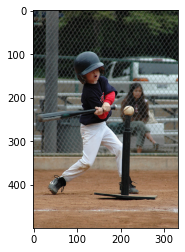


For image :: ../input/coco-2017-dataset/coco2017/train2017/000000298493.jpg

Inference caption output:
startseq man swinging bat at ball endseq

Original caption 1  :::  young kid playing tee ball with young woman watching
Original caption 2  :::  boy is swinging bat at tball stand
Original caption 3  :::  young child up to bat during teeball
Original caption 4  :::  young boy playing game of tee ball
Original caption 5  :::  small boy takes swing at tball stand




--------  Inference for position 1  --------


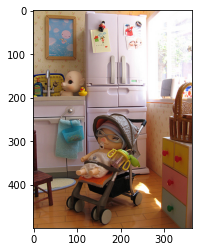


For image :: ../input/coco-2017-dataset/coco2017/train2017/000000545705.jpg

Inference caption output:
startseq small living room with lots of furniture endseq

Original caption 1  :::  doll is sitting in stroller with pacifier in its mouth
Original caption 2  :::  toy baby in toy stroller in toy kitchen
Original caption 3  :::  doll in toy stroller in childs playroom
Original caption 4  :::  toy pig in baby stroller in kitchen
Original caption 5  :::  piggy doll is in small stroller




--------  Inference for position 2  --------


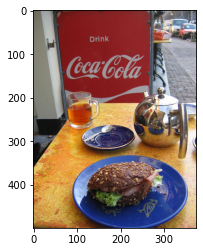


For image :: ../input/coco-2017-dataset/coco2017/train2017/000000270004.jpg

Inference caption output:
startseq table with plates of food on it endseq

Original caption 1  :::  sandwich sits on plate outside on table
Original caption 2  :::  picture of some food and drink on the table
Original caption 3  :::  sandwich is on plate with mug kettle and coke sign behind it
Original caption 4  :::  sandwich on blue plate with pot of tea
Original caption 5  :::  plate of food on table near drink




--------  Inference for position 3  --------


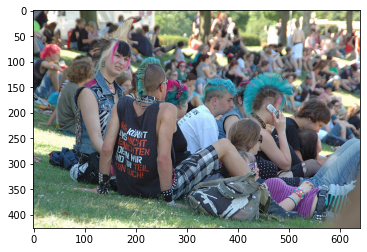


For image :: ../input/coco-2017-dataset/coco2017/train2017/000000042804.jpg

Inference caption output:
startseq group of people sitting around table with food endseq

Original caption 1  :::  group of young punk rockers at festival
Original caption 2  :::  crowd of emo hipsters sitting together on park
Original caption 3  :::  large crowd of people sitting in the park
Original caption 4  :::  teenagers sitting on the grass with colored hair
Original caption 5  :::  the group at the concert is having good time




--------  Inference for position 4  --------


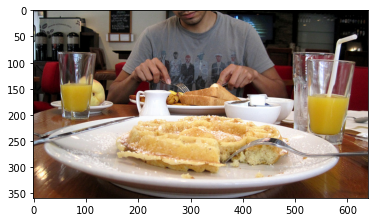


For image :: ../input/coco-2017-dataset/coco2017/train2017/000000089052.jpg

Inference caption output:
startseq table with two plates of food on it endseq

Original caption 1  :::  there is close up of belgium waffle with powdered sugar on it
Original caption 2  :::  man sitting at dinner table in front of white plate of food
Original caption 3  :::  waffle is sitting on plate with fork near glass of orange juice
Original caption 4  :::  male in gray shirt sitting at table with food and drinks
Original caption 5  :::  two people are eating breakfast at restaurant




--------  Inference for position 5  --------


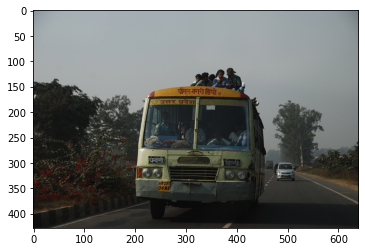


For image :: ../input/coco-2017-dataset/coco2017/train2017/000000032809.jpg

Inference caption output:
startseq man standing in front of bus with large open open endseq

Original caption 1  :::  bus with arabic writing and people on top of it
Original caption 2  :::  passenger bus travels down road straddling the center line
Original caption 3  :::  bus driving down street with people seated on the roof of the bus
Original caption 4  :::  bus is traveling down the road with many passengers
Original caption 5  :::  bus with people riding on the roof




--------  Inference for position 6  --------


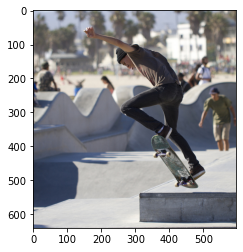


For image :: ../input/coco-2017-dataset/coco2017/train2017/000000139658.jpg

Inference caption output:
startseq man is riding his skateboard down the street endseq

Original caption 1  :::  gentleman is trying to pull off his skateboarding trick
Original caption 2  :::  man on skateboard jumping over ledge
Original caption 3  :::  man riding his skateboard on skate park
Original caption 4  :::  man riding skateboard off the side of ramp
Original caption 5  :::  skater at the venice beach skate park working on his tricks




--------  Inference for position 7  --------


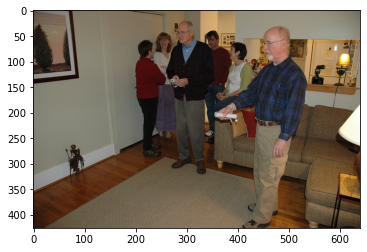


For image :: ../input/coco-2017-dataset/coco2017/train2017/000000296766.jpg

Inference caption output:
startseq group of people standing around table with wine glasses endseq

Original caption 1  :::  these two older gentlemen are playing video game
Original caption 2  :::  two old men playing wii game in party
Original caption 3  :::  man that is playing wii in living room
Original caption 4  :::  couple of men that are on carpet with remote
Original caption 5  :::  man and his family play with ninteno wii




--------  Inference for position 8  --------


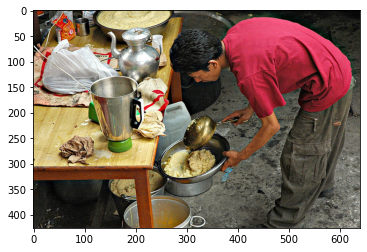


For image :: ../input/coco-2017-dataset/coco2017/train2017/000000372498.jpg

Inference caption output:
startseq man is pouring wine into glass of food endseq

Original caption 1  :::  man bending over scooping food into pan
Original caption 2  :::  man is putting porridge substance into floor pan
Original caption 3  :::  man scooping food from pan near cluttered wooden table
Original caption 4  :::  man is pouring the contents of pan into bucket
Original caption 5  :::  man scooping food into pan




--------  Inference for position 9  --------


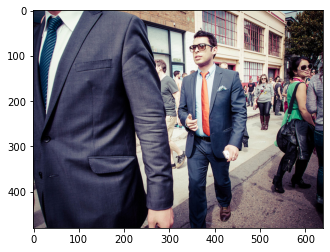


For image :: ../input/coco-2017-dataset/coco2017/train2017/000000050939.jpg

Inference caption output:
startseq group of people standing next to each other endseq

Original caption 1  :::  man in shirt and tie walking on street next to building
Original caption 2  :::  man in suit and orange tie walks through crowd
Original caption 3  :::  two guys in suits are walking down the street near others
Original caption 4  :::  crowd of people walking along sidewalk in different directions
Original caption 5  :::  some people on street and one is wearing an orange tie






In [59]:
for infer_idx_pos in range(50):
  print(f"--------  Inference for position {infer_idx_pos}  --------")
  do_inference_one_image(infer_idx_pos, val_imgs_arr, IPDIR_IMGS, MAX_LENGTH_CAPTION, reloaded_RNN_decoder, descriptions)
  print(f"\n\n\n")

## RELOAD - MODEL 2
### Weights File: /content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoVal2017_1/Weights/rbewoor_Encoder_Weights_Ph2_ep4.h5

### Using the last epochs weight file

### Training Specs:
### Total 10 epochs, first 5 epochs with smaller BS and larger LR, last 5 epochs with larger BS but smaller LR, MAX_LENGTH_CAPTION = 45, VOCAB_SIZE = 1523, loss='categorical_crossentropy', optimizer='adam', train=4800 images


### The weights file was exported earlier using: model_RNN_decoder.save_weights(SAVE_TO_PATH)

In [ ]:
Training Phase 1 started at :: 2020-09-18 22:10:51

Phase 1 parameters:
STEPS_PER_EPOCH_1 = 1200
BATCH_SIZE_1 = 4
N_EPOCHS_1 = 5
WARNING:tensorflow:From <ipython-input-47-83b52223b490>:21: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
1200/1200 [==============================] - 585s 488ms/step - loss: 4.7801
1200/1200 [==============================] - 599s 499ms/step - loss: 3.8539
1200/1200 [==============================] - 584s 487ms/step - loss: 3.5118
1200/1200 [==============================] - 585s 487ms/step - loss: 3.3086
1200/1200 [==============================] - 579s 483ms/step - loss: 3.1668


Training Phase 2 started at :: 2020-09-18 22:59:49

Phase 2 parameters:
STEPS_PER_EPOCH_2 = 600
BATCH_SIZE_2 = 8
N_EPOCHS_2 = 5
600/600 [==============================] - 536s 894ms/step - loss: 3.0436
600/600 [==============================] - 543s 904ms/step - loss: 2.9905
600/600 [==============================] - 550s 916ms/step - loss: 2.9629
600/600 [==============================] - 553s 922ms/step - loss: 2.9448
600/600 [==============================] - 566s 943ms/step - loss: 2.9222

In [ ]:
def reload_rnn_encoder_saved_weights(_saved_weights_file, _EMBEDDING_DIMS, _VOCAB_SIZE, _MAX_LENGTH_CAPTION):
  if os.path.exists(_saved_weights_file) and os.path.isfile(_saved_weights_file):
    ## Decoder Model defining

    ## parameters to define model
    #EMBEDDING_DIMS is initialised earlier while creating embedding matrix
    #VOCAB_SIZE is initialised earlier
    #MAX_LENGTH_CAPTION is initialised earlier

    inputs1 = keras.Input(shape=(2048,))
    fe1 = keras.layers.Dropout(0.5)(inputs1)
    fe2 = keras.layers.Dense(256, activation='relu')(fe1)

    # partial caption sequence model
    inputs2 = keras.Input(shape=(_MAX_LENGTH_CAPTION,))
    se1 = keras.layers.Embedding(_VOCAB_SIZE, _EMBEDDING_DIMS, mask_zero=True)(inputs2)
    se2 = keras.layers.Dropout(0.5)(se1)
    se3 = keras.layers.LSTM(256)(se2)

    # decoder (feed forward) model
    decoder1 = keras.layers.add([fe2, se3])
    decoder2 = keras.layers.Dense(256, activation='relu')(decoder1)
    outputs = keras.layers.Dense(_VOCAB_SIZE, activation='softmax')(decoder2)

    # merge the two input models
    reloaded_rnn_decoder_model = keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)

    print(f"\nRNN Decoder model defined with these paramenters:\nEMBEDDING_DIMS = {_EMBEDDING_DIMS} , VOCAB_SIZE = {_VOCAB_SIZE} , MAX_LENGTH_CAPTION = {_MAX_LENGTH_CAPTION}\nAttempting to load weights...")
    
    ## load the weights
    reloaded_rnn_decoder_model.load_weights(_saved_weights_file)
    print(f"SUCCESS - Reloaded weights from :: {_saved_weights_file}")
    return reloaded_rnn_decoder_model
  else:
    print(f"\nERROR reloading weights. Check weights file exists here = {_saved_weights_file} ;\nOR model setup parameters incompatible with the saved weights file given.")
    return None

def greedySearch(_decoder_model, _img_encoding, _max_length):
  in_text = 'startseq'
  for i in range(_max_length):
    sequence = [ wordtoix[w] for w in in_text.split() if w in wordtoix ]
    sequence = keras.preprocessing.sequence.pad_sequences([sequence], maxlen=_max_length)
    yhat = _decoder_model.predict([_img_encoding,sequence], verbose=0)
    yhat = np.argmax(yhat)
    word = ixtoword[yhat]
    in_text += ' ' + word
    if word == 'endseq':
      break
  caption_out = in_text.split()
  #caption_out = caption_out[1:-1]  ## drop the startseq and endseq words at either end
  caption_out = ' '.join(caption_out)
  return caption_out

def do_inference_one_image(_infer_idx_pos, _imgs_arr, _IPDIRIMGS, _MAX_LENGTH_CAPTION, _model_RNN_decoder, _descriptions):
  infer_image_path = _IPDIRIMGS + _imgs_arr[_infer_idx_pos] + '.jpg'

  ## show the original image
  image = img_encodings[ _imgs_arr[_infer_idx_pos] ].reshape((1,2048))
  x = plt.imread(infer_image_path)
  plt.imshow(x)
  plt.show()

  ## get the prediction caption using greedy search
  predicted_caption = greedySearch(_model_RNN_decoder, image, _MAX_LENGTH_CAPTION)
  print(f"\nFor image :: {infer_image_path}\n\nInference caption output:\n{ predicted_caption }")
  print("")
  ## show the original captions
  for idx, orig_cap in enumerate(_descriptions.get(_imgs_arr[_infer_idx_pos])):
    print(f"Original caption {idx+1}  :::  {orig_cap}")

In [ ]:
SAVED_WEIGHTS_PATH = OPDIR + r'Weights/' + 'rbewoor_Encoder_Weights_Ph2_ep4.h5'
SAVED_WEIGHTS_PATH

In [ ]:
print(f"EMBEDDING_DIMS = {EMBEDDING_DIMS}, VOCAB_SIZE = {VOCAB_SIZE}, MAX_LENGTH_CAPTION = {MAX_LENGTH_CAPTION}")
reloaded_RNN_decoder = reload_rnn_encoder_saved_weights(SAVED_WEIGHTS_PATH, EMBEDDING_DIMS, VOCAB_SIZE, MAX_LENGTH_CAPTION)
type(reloaded_RNN_decoder)

In [ ]:
for infer_idx_pos in range(10):
  print(f"--------  Inference for position {infer_idx_pos}  --------")
  do_inference_one_image(infer_idx_pos, val_imgs_arr, IPDIRIMGS, MAX_LENGTH_CAPTION, reloaded_RNN_decoder, descriptions)
  print(f"\n\n\n")

In [ ]:
print(f"EMBEDDING_DIMS = {EMBEDDING_DIMS}, VOCAB_SIZE = {VOCAB_SIZE}, MAX_LENGTH_CAPTION = {MAX_LENGTH_CAPTION}")
reloaded_RNN_decoder = reload_rnn_encoder_saved_weights(SAVED_WEIGHTS_PATH, EMBEDDING_DIMS, VOCAB_SIZE, MAX_LENGTH_CAPTION)
type(reloaded_RNN_decoder)

In [ ]:
for infer_idx_pos in range(10):
  print(f"--------  Inference for position {infer_idx_pos}  --------")
  do_inference_one_image(infer_idx_pos, val_imgs_arr, IPDIRIMGS, MAX_LENGTH_CAPTION, reloaded_RNN_decoder, descriptions)
  print(f"\n\n\n")

## NEXT SECTION - PENDING